•Implementar un modelo de clasificación para predecir la
enfermedad de las hojas de mango

• Crear un vector de
características combinando las
características vistas en clase

• Usar el modelo de clasificación
de su preferencia (Redes
Neuronales, Árboles, KNN, …)

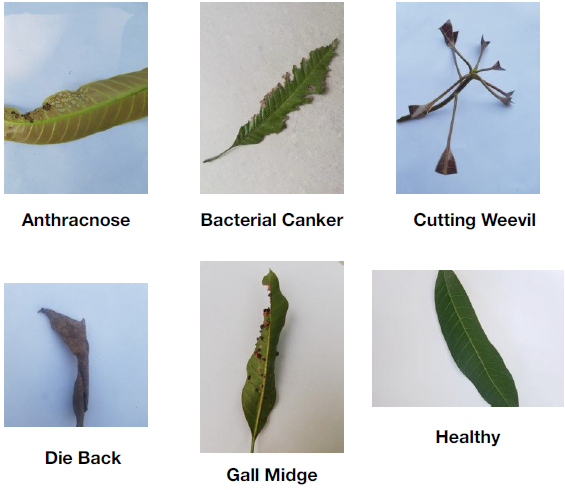

Link dataset: https://drive.google.com/file/d/1KXWbGMu3Kiv9ghg-BWRA3z3Uvb0q4gXr/view

In [2]:
# Se importan las librerías necesarias
import os
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [4]:
# Se crea una función para extraer las características propias de cada categoría
def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # HOG
    hog_features, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)

    # ORB Keypoints
    orb = cv2.ORB_create()
    keypoints, orb_features = orb.detectAndCompute(gray, None)
    if orb_features is None:
        orb_features = np.zeros(128)
    else:
        orb_features = orb_features.flatten()
        if len(orb_features) < 128:
            orb_features = np.pad(orb_features, (0, 128 - len(orb_features)), 'constant')
        else:
            orb_features = orb_features[:128]  # Truncar si es mayor a 128

    # Histograma de intensidades
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).flatten()

    # LBP (Local Binary Patterns)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 59), range=(0, 58))

    # Concatena todas las características en un vector
    features = np.hstack([hog_features, orb_features, hist, lbp_hist])
    return features

In [5]:
# Carga imágenes desde carpetas y extrae características
def carga_imagenes(folder_path):
    features = []
    labels = []
    for label_folder in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label_folder)
        if not os.path.isdir(label_path):
            continue
        label = label_folder  # El nombre de la carpeta es la etiqueta (enfermedad)
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.resize(image, (128, 128))
                feature_vector = extract_features(image)
                if feature_vector is not None and feature_vector.size > 0:
                    features.append(feature_vector)
                    labels.append(label)
                else:
                    print(f"Error extrayendo características de la imagen: {img_path}")
            else:
                print(f"Error cargando la imagen: {img_path}")
    return np.array(features), np.array(labels)

# Ruta a la carpeta con imágenes
folder_path = '/content/drive/MyDrive/ComputerVision/Ejercicios/Semana10/mango_leaf_disease/'
X, y = carga_imagenes(folder_path)

# Verifica si las características y etiquetas se han cargado correctamente
print(f"Total de imágenes procesadas: {len(X)}")
print(f"Dimensiones de las características: {X.shape}")

# Continua cuando encuentra los datos
if X.shape[0] > 0:
    # Convierte etiquetas a clases numéricas
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Divide los datos en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

    # Crea el modelo KNN
    knn = KNeighborsClassifier(n_neighbors=5)

    # Entrena el modelo
    knn.fit(X_train, y_train)

    # Predice con el modelo usando datos del conjunto de prueba
    y_pred = knn.predict(X_test)

    # Evalua el modelo
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
else:
    print("No se encontraron características. Verifica la carga de las imágenes y la extracción de características.")

Total de imágenes procesadas: 4000
Dimensiones de las características: (4000, 8542)
                  precision    recall  f1-score   support

     Anthracnose       0.78      0.56      0.65       112
Bacterial Canker       0.70      0.99      0.82        91
  Cutting Weevil       1.00      0.81      0.90       101
        Die Back       0.69      0.94      0.80        86
      Gall Midge       0.72      0.82      0.77       123
         Healthy       0.78      0.51      0.62        90
  Powdery Mildew       0.70      0.80      0.74        93
     Sooty Mould       0.76      0.62      0.68       104

        accuracy                           0.75       800
       macro avg       0.77      0.76      0.75       800
    weighted avg       0.77      0.75      0.75       800

